# Data preparation & cleaning

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

In [2]:
test=pd.read_csv('test_table.csv')
user=pd.read_csv('user_table.csv')

In [3]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
test.info()
# There is no missing value. The null value in ads_channel indicates the user didn't come via an ad.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [5]:
df=pd.merge(test,user,how='left',on='user_id')
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [6]:
df.info()
# The last 3 columns are shorter than the others, indicating that not all users in the test table have personal information.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           453321 non-null  int64  
 1   date              453321 non-null  object 
 2   source            453321 non-null  object 
 3   device            453321 non-null  object 
 4   browser_language  453321 non-null  object 
 5   ads_channel       181877 non-null  object 
 6   browser           453321 non-null  object 
 7   conversion        453321 non-null  int64  
 8   test              453321 non-null  int64  
 9   sex               452867 non-null  object 
 10  age               452867 non-null  float64
 11  country           452867 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


In [7]:
df.describe()
# It seems like there is no abnormal data.

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


# Check the original conversion rates among countries

In [8]:
df[df['test']==0].groupby('country').agg({'conversion':'mean'}).sort_values('conversion',ascending=False)
# Spain-based users do have the highest conversion rate when using the old translation.

,conversion
country,
Spain,0.079719
El Salvador,0.053554
Nicaragua,0.052647
Costa Rica,0.052256
Colombia,0.052089
Honduras,0.050906
Guatemala,0.050643
Venezuela,0.050344
Peru,0.049914


# A/B testing
[sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html)

In [9]:
df_ab=df[df['country']!='Spain']

In [10]:
df_ab.groupby(['test']).agg({'user_id':'count'})
# The sample size in each group is large enough. We can use a sample size calculator to check (click the link above).

,user_id
test,
0,185556
1,215983


In [11]:
df_ab.groupby(['test']).agg({'conversion':'mean'})
# The conversion rate of the old version is higher than that of the new version.

,conversion
test,
0,0.048330
1,0.043425


In [12]:
# number of users
n_old=len(df_ab[df_ab['test']==0])
n_new=len(df_ab[df_ab['test']==1])

# number of converted users
c_old=len(df_ab[(df_ab['test']==0)&(df_ab['conversion']==1)])
c_new=len(df_ab[(df_ab['test']==1)&(df_ab['conversion']==1)])

# conversion rate
p_old=c_old/n_old
p_new=c_new/n_new

# total conversion rate across two groups
p=(c_old+c_new)/(n_old+n_new)

# pooled standard deviation
s=np.sqrt(p*(1-p)*(1/n_old+1/n_new))

# test statistic
z=(p_new-p_old)/s

In [13]:
z_alpha=norm.ppf(0.025)
abs(z)<abs(z_alpha)
# We refuse the null hypothesis that the effect is insignificant

False

In [14]:
z>0
# The new version has a negative effect.

False

# Further investigate

In [15]:
old_version=df_ab[df_ab['test']==0].groupby('country').agg({'conversion':'mean'})
new_version=df_ab[df_ab['test']==1].groupby('country').agg({'conversion':'mean'})
country_cr=pd.concat([old_version,new_version],axis=1)
country_cr.columns=['old','new']
country_cr['difference']=country_cr['new']-country_cr['old']
country_cr['sign']=country_cr['difference'].apply(lambda x: '+' if x>0 else '-')
country_cr

,old,new,difference,sign
country,,,,
Argentina,0.015071,0.013725,-0.001346,-
Bolivia,0.049369,0.047901,-0.001468,-
Chile,0.048107,0.051295,0.003188,+
Colombia,0.052089,0.050571,-0.001519,-
Costa Rica,0.052256,0.054738,0.002482,+
Ecuador,0.049154,0.048988,-0.000165,-
El Salvador,0.053554,0.047947,-0.005607,-
Guatemala,0.050643,0.048647,-0.001996,-
Honduras,0.050906,0.047540,-0.003366,-


# Cohen's d

In [16]:
s_co=np.sqrt(((n_old-1)*p_old*(1-p_old)+(n_new-1)*p_new*(1-p_new))/(n_old+n_new-2))
d=(p_new-p_old)/s_co

In [17]:
print('The conversion rate of the new version is {0} standard deviations less than that of the old version.'.format(abs(round(d,4))))

The conversion rate of the new version is 0.0235 standard deviations less than that of the old version.


According to Part 3 to Part 5, though we reject the null hypothesis in A/B testing, the new translation is not totally negative and Cohen's d test also verifies that the negative effect is small.\
\
Possible reasons:
1. The test doesn't follow a ramdom sampling.
2. The time span is too small to reflect the true reaction of the users.

# Verify the possible reasons

## Possible reason 1

In [18]:
old_size=df_ab[df_ab['test']==0].groupby('country')['user_id'].count()
new_size=df_ab[df_ab['test']==1].groupby('country')['user_id'].count()
country_size=pd.concat([old_size,new_size],axis=1)
country_size.columns=['old','new']
country_size['proportion']=country_size['new']/country_size['old']
country_size.sort_values(['proportion'],ascending=False)

,old,new,proportion
country,,,
Uruguay,415,3719,8.961446
Argentina,9356,37377,3.994976
Paraguay,3650,3697,1.012877
Panama,1966,1985,1.009664
Bolivia,5550,5574,1.004324
Chile,9853,9884,1.003146
Mexico,64209,64275,1.001028
Costa Rica,2660,2649,0.995865
Peru,16869,16797,0.995732


To run a valid A/B test, we should make sure that users in all the above countries ate covered in both control group and experiment group, and in roughly the same proportion. However, the table shows that there is a huge disproportion for Argentina and Uruguay. The allocation failure might bias our test result.

## Possible reason 2

In [19]:
df_ab.groupby(['date','test']).count()

user_id  source  device  browser_language  ads_channel  \
date       test                                                           
2015-11-30 0       29020   29020   29020             29020        11640   
           1       33883   33883   33883             33883        13477   
2015-12-01 0       29036   29036   29036             29036        11674   
           1       33875   33875   33875             33875        13701   
2015-12-02 0       28939   28939   28939             28939        11685   
           1       33549   33549   33549             33549        13509   
2015-12-03 0       40784   40784   40784             40784        16215   
           1       47420   47420   47420             47420        18955   
2015-12-04 0       57777   57777   57777             57777        23241   
           1       67256   67256   67256             67256        26887   

                 browser  conversion    sex    age  country  
date       test                                              
2015-11-30 0       29020       29020  28982  28982    28982  
           1       33883       33883  33844  33844    33844  
2015-12-01 0       29036       29036  28995  28995    28995  
           1       33875       33875  33840  33840    33840  
2015-12-02 0       28939       28939  28903  28903    28903  
           1       33549       33549  33517  33517    33517  
2015-12-03 0       40784       40784  40727  40727    40727  
           1       47420       47420  47383  47383    47383  
2015-12-04 0       57777       57777  57704  57704    57704  
           1       67256       67256  67190  67190    67190

The test only lasted 5 days, which might be too short. It is possible that the test results we got is momentary, since emotion change needs time. We cannot rule out the existence of primacy effect and novelty effect as well.\
We can run an A/A test to eliminate the statistical bias.

# visual exploration

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df_plot=df_ab.dropna(subset=['sex','age','country'])
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401085 entries, 1 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           401085 non-null  int64  
 1   date              401085 non-null  object 
 2   source            401085 non-null  object 
 3   device            401085 non-null  object 
 4   browser_language  401085 non-null  object 
 5   ads_channel       160800 non-null  object 
 6   browser           401085 non-null  object 
 7   conversion        401085 non-null  int64  
 8   test              401085 non-null  int64  
 9   sex               401085 non-null  object 
 10  age               401085 non-null  float64
 11  country           401085 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 39.8+ MB


In [22]:
df_plot.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico


In [23]:
df_plot_old=df_plot[df_plot['test']==0]
df_plot_new=df_plot[df_plot['test']==1]

df_old_age=df_plot_old.groupby(['age']).agg({'conversion':'mean'})
df_new_age=df_plot_new.groupby(['age']).agg({'conversion':'mean'})
df_age=pd.concat([df_old_age,df_new_age],axis=1)
df_age.dropna(how='any',inplace=True)
df_age.columns=['old','new']
df_age.reset_index(inplace=True)

<IPython.core.display.Javascript object>


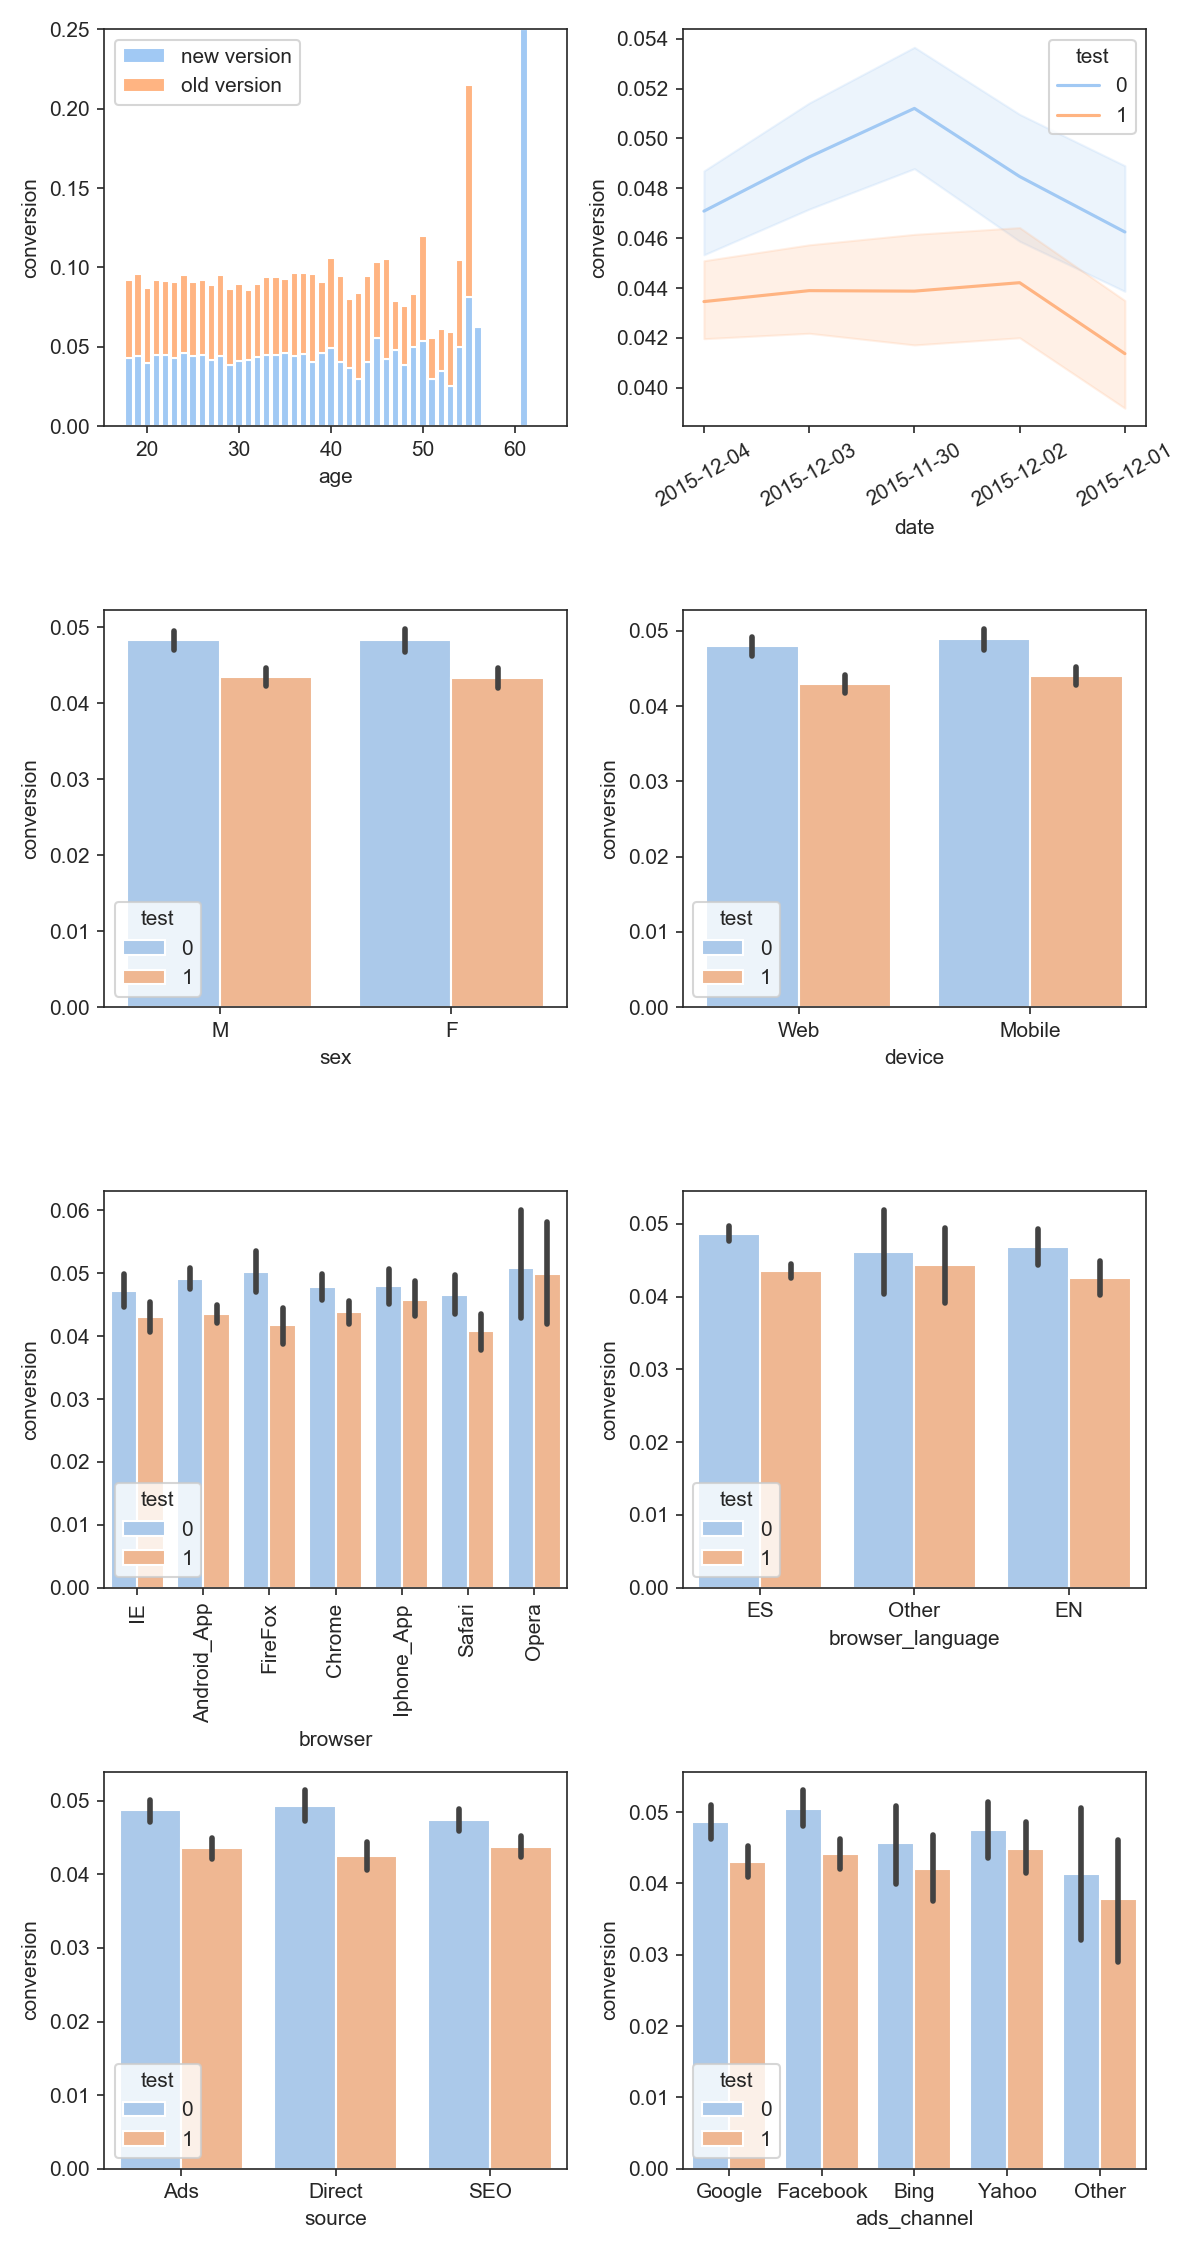

In [24]:
%matplotlib notebook
sns.set_palette('pastel')
sns.set_style('ticks')
fig = plt.figure(figsize=(8,15))

ax1 = fig.add_subplot(4,2,1)
plt.bar(df_age.age,df_age.new)
plt.bar(df_age.age,df_age.old,bottom=df_age.new)
plt.legend(['new version','old version'])
plt.xlabel('age')
plt.ylabel('conversion')

ax2 = fig.add_subplot(4,2,2)
sns.lineplot(x='date',y='conversion',data=df_plot,hue='test')
plt.xticks(rotation=30)

ax3 = fig.add_subplot(4,2,3)
sns.barplot(x='sex',y='conversion',data=df_plot,hue='test')

ax4 = fig.add_subplot(4,2,4)
sns.barplot(x='device',y='conversion',data=df_ab,hue='test')

ax5 = fig.add_subplot(4,2,5)
sns.barplot(x='browser',y='conversion',data=df_ab,hue='test')
plt.xticks(rotation=90)

ax6 = fig.add_subplot(4,2,6)
sns.barplot(x='browser_language',y='conversion',data=df_ab,hue='test')

ax7 = fig.add_subplot(4,2,7)
sns.barplot(x='source',y='conversion',data=df_ab,hue='test')

ax8 = fig.add_subplot(4,2,8)
sns.barplot(x='ads_channel',y='conversion',data=df_ab,hue='test')
plt.tight_layout();